In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from matplotlib import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX


sns.set(style='darkgrid', palette='muted', font_scale=1, rc={'figure.figsize':(20,10)})

RANDOM_SEED = 40
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [49]:
def load_data(path, columns, start=None, stop=None):
    df = pd.read_pickle(path)
    return df.loc[start:stop, columns]

In [50]:
df = load_data('../../data/ica_summary.pkl', columns=['artiklar'], stop='2021-03-28')

### Create all features

In [51]:
def icas_egna_features(df):
    features = {}

    def add_weekday(features):
        features['weekday'] = pd.Series(df.index.weekday, index=df.index)
    
    def add_day_of_month(features):
        features['day_of_month'] = pd.Series(df.index.day, index=df.index)
    
    def add_holiday(features):
        holidays = ['2021-01-01', '2021-01-06', '2021-04-02', '2021-04-04', '2021-04-05', '2020-05-21', '2020-05-31', '2020-06-06', '2020-06-20', '2020-10-31', '2020-12-25', '2020-12-26']
        features['holiday'] = pd.Series(np.where(df.index.isin(holidays), 1, 0), index=df.index)
    
    def add_before_holiday(features):
        features['before_holiday'] = pd.Series(0, index=df.index)
        before_holidays = ['2021-01-01', '2021-04-02', '2020-06-06', '2020-12-24']
        for holiday in before_holidays:
            for i in range(1, 4):
                features['before_holiday'][pd.to_datetime(holiday) - pd.DateOffset(i)] = i
    
    def add_payday(features, payday, pension=False):
        if pension:
            if 'pension' not in features:
                features['pension'] = pd.Series(0, index=df.index) 
                series = features['pension']
            else:
                series = features['pension']
                
        if not pension:
            features['payday'] = pd.Series(0, index=df.index)
            series = features['payday']
        
        for i, day in enumerate(features['day_of_month']):
            if day == payday:
                if features['weekday'].iloc[i] in [5, 6] or features['holiday'].iloc[i]:
                    paydays = i - 1 if features['weekday'].iloc[i-1] not in [5, 6] or features['holiday'].iloc[i -1] else i - 2
                    series.iloc[paydays] = 1 
                else:
                    series.iloc[i] = 1
    
    add_weekday(features)
    add_day_of_month(features)
    add_holiday(features)
    add_before_holiday(features)
    add_payday(features, 25)
    add_payday(features, 18, pension=True)
    add_payday(features, 17, pension=True)

    return features

In [52]:
features = icas_egna_features(df)
for k, v in features.items():
    print(type(v))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Feature engineering

In [113]:
def add_basic_combination_feature(df, features):
    df_list = [df]
    for i, feat in enumerate(features, 1):
        ts = df.copy()
        for j in range(i):
            ts[list(features.keys())[j]] = list(features.values())[j]
        df_list.append(ts)
    return df_list

In [115]:
df_list = add_basic_combination_feature(df, features)

In [11]:
from itertools import combinations, chain

def feature_combinations(df, features):
    features_combinations = list(chain.from_iterable([combinations(features, i) for i in range(1, len(features))]))

    df_list = [df]
    for f_comb in features_combinations:
        ts = df.copy()
        for feat in f_comb:
            ts[feat] = features[feat]
        df_list.append(ts)
    
    return df_list

In [12]:
df_list = feature_combinations(df, features)
df_list = df_list

In [13]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

def scale_data(df_list):
    scaled_df_list = []
    for df in df_list:
        min_max_scaler_x = MinMaxScaler(feature_range=(0, 1))
        min_max_scaler_y = MinMaxScaler(feature_range=(0, 1))

        robust_scaler_x = RobustScaler()
        robust_scaler_y = RobustScaler()

        standard_scaler_x = StandardScaler()
        standard_scaler_y = StandardScaler()
        
        scalers = [[min_max_scaler_x, min_max_scaler_y], [robust_scaler_x, robust_scaler_y], [standard_scaler_x, standard_scaler_y]]

        if len(df.columns) == 1:
            scaled_df_list.append({'X': df.iloc[:].to_numpy().reshape(-1, 1), 
                                   'y': df.iloc[:].to_numpy().reshape(-1, 1), 
                                   'scaler_x': None, 
                                   'scaler_y': None,
                                   'features': df.columns})
        else:
            scaled_df_list.append({'X': df.iloc[:, 1:].to_numpy(), 
                                   'y': df.iloc[:, 0].to_numpy().reshape(-1, 1), 
                                   'scaler_x': None, 
                                   'scaler_y': None,
                                   'features': df.columns})

        for scaler in scalers:
            if len(df.columns) == 1:
                scaled_df_list.append({'X': scaler[0].fit_transform(df.iloc[:].to_numpy().reshape(-1, 1)), 
                                       'y': scaler[1].fit_transform(df.iloc[:].to_numpy().reshape(-1, 1)), 
                                       'scaler_x': scaler[0], 
                                       'scaler_y': scaler[1],
                                       'features': df.columns})
            else:
                scaled_df_list.append({'X': scaler[0].fit_transform(df.iloc[:, 1:].to_numpy()), 
                                       'y': scaler[1].fit_transform(df.iloc[:, 0].to_numpy().reshape(-1, 1)), 
                                       'scaler_x': scaler[0], 
                                       'scaler_y': scaler[1],
                                       'features': df.columns})
    
    return scaled_df_list

In [116]:
scaled_data = scale_data(df_list)

In [117]:
def split_train_test(scaled_data, test_size):
    
    return [{'X_train': df['X'][:len(df['X']) - test_size], 
             'y_train': df['y'][:len(df['X']) - test_size],
             'X_test': df['X'][len(df['X']) - test_size:],
             'y_test': df['y'][len(df['X']) - test_size:],
             'scaler_x': df['scaler_x'],
             'scaler_y': df['scaler_y'],
             'features': df['features']} 
             for df in scaled_data]

In [118]:
train_test = split_train_test(scaled_data, 7)
print(len(train_test))

28


In [119]:
def visualize_y(df):
    seas_d = sm.tsa.seasonal_decompose(df_list[0].artiklar, model='add', period=14)

    fig = seas_d.plot()
    fig.set_figheight(10)
    plt.show()
    
    fig, ax = plt.subplots(2,1, figsize=(20,5))
    fig = sm.tsa.graphics.plot_acf(train_test[0]['y_train'], lags=50, ax=ax[0])
    fig = sm.tsa.graphics.plot_pacf(train_test[0]['y_train'], lags=50, ax=ax[1])
    plt.show()

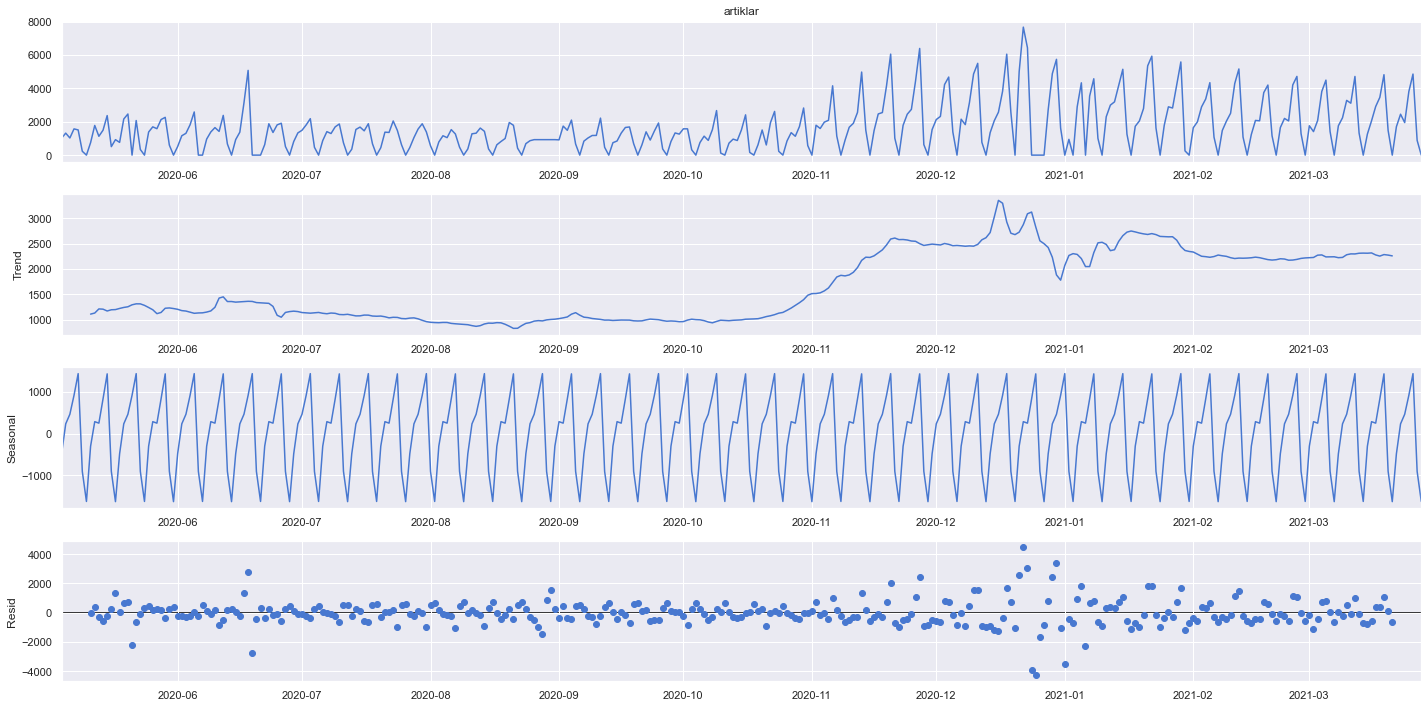

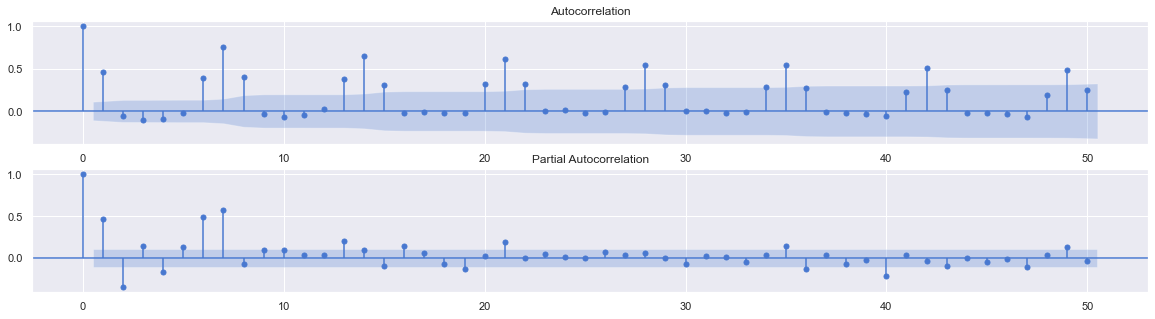

In [120]:
visualize_y(train_test)

In [121]:
def find_optimal_params(df_list):
    trained_df = []
    for i, df in enumerate(df_list, 1):
        print(f'> Training {i}/{len(df_list)} <'.center(50, '-'))
        step_wise = auto_arima(df['y_train'], 
                           exogenous=df['X_train'] if (df['X_test']!=df['y_test']).all() else None,
                           start_P=0, max_P=7,
                           D=1, max_D=7,
                           start_Q=0, max_Q=7,
                           start_p=1, start_q=1, 
                           max_p=7, max_q=7, 
                           d=1, max_d=7,
                           m=7,
                           seasonal=True,
                           trace=True,
                           error_action='ignore', 
                           suppress_warnings=True, 
                           stepwise=True)
        trained_df.append({**df, **{'order': step_wise.order,
                                    'seasonal_order': step_wise.seasonal_order}})
    
    return trained_df

In [122]:
optimized_df = find_optimal_params(train_test)

----------------> Training 1/28 <-----------------
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=5362.754, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=5318.381, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=5347.630, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=5288.676, Time=1.03 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=5288.485, Time=1.62 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=5267.317, Time=2.65 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=5262.110, Time=4.82 sec
 ARIMA(1,1,0)(6,1,0)[7]             : AIC=5256.528, Time=6.49 sec
 ARIMA(1,1,0)(7,1,0)[7]             : AIC=5256.385, Time=10.85 sec
 ARIMA(1,1,0)(7,1,1)[7]             : AIC=5249.885, Time=24.54 sec
 ARIMA(1,1,0)(6,1,1)[7]             : AIC=5248.033, Time=21.79 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=5246.138, Tim

In [26]:
optimized_df[0]

{'X_train': array([[ 6, 15,  0],
        [ 0, 16,  0],
        [ 1, 17,  1],
        [ 2, 18,  1],
        [ 3, 19,  0],
        [ 4, 20,  0],
        [ 5, 21,  0],
        [ 6, 22,  0],
        [ 0, 23,  0],
        [ 1, 24,  0],
        [ 2, 25,  0],
        [ 3, 26,  0],
        [ 4, 27,  0],
        [ 5, 28,  0],
        [ 6, 29,  0],
        [ 0, 30,  0],
        [ 1,  1,  0],
        [ 2,  2,  0],
        [ 3,  3,  0],
        [ 4,  4,  0],
        [ 5,  5,  0],
        [ 6,  6,  0],
        [ 0,  7,  0],
        [ 1,  8,  0],
        [ 2,  9,  0],
        [ 3, 10,  0],
        [ 4, 11,  0],
        [ 5, 12,  0],
        [ 6, 13,  0],
        [ 0, 14,  0],
        [ 1, 15,  0],
        [ 2, 16,  0],
        [ 3, 17,  1],
        [ 4, 18,  1],
        [ 5, 19,  0],
        [ 6, 20,  0],
        [ 0, 21,  0],
        [ 1, 22,  0],
        [ 2, 23,  0],
        [ 3, 24,  0],
        [ 4, 25,  0],
        [ 5, 26,  0],
        [ 6, 27,  0],
        [ 0, 28,  0],
        [ 1, 29,  0],

In [123]:
import pickle
def save_results(df_list, name):
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(df_list, f)

In [124]:
def run_model(df_list):
    fitted_df = []
    for i, df in enumerate(df_list, 1):
        model = SARIMAX(df['y_train'],
                     exog=df['X_train'] if (df['X_test']!=df['y_test']).all() else None,
                     order=df['order'],
                     seasonal_order=df['seasonal_order'],
                     enforce_invertibility=False,
                     enforce_stationarity=False)
        print(f'> Fitting model {i}/{len(df_list)} <'.center(50, '-'))
        results = model.fit()
        
        forecast = results.get_forecast(steps=7, exog=df['X_test'] if (df['X_test']!=df['y_test']).all() else None)
        
        if df['scaler_y']:
            y_true = df['scaler_y'].inverse_transform(df['y_test'])
            y_pred = df['scaler_y'].inverse_transform(forecast.predicted_mean.reshape(-1, 1))

            fitted_df.append({**df, **{'forecast_mean': y_pred,
                                       'forecast_low': df['scaler_y'].inverse_transform(np.fromiter(map(lambda x: x[0], forecast.conf_int()), dtype=np.float).reshape(-1, 1)),
                                       'forecast_high': df['scaler_y'].inverse_transform(np.fromiter(map(lambda x: x[1], forecast.conf_int()), dtype=np.float).reshape(-1, 1)),
                                       'score': {'RMSE': np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)),
                                                 'MAE': mean_absolute_error(y_true=y_true, y_pred=y_pred),
                                                 'r2': r2_score(y_true=y_true, y_pred=y_pred)}}})
        else:
            fitted_df.append({**df, **{'forecast_mean': forecast.predicted_mean,
                           'forecast_low': list(map(lambda x: x[0], forecast.conf_int())),
                           'forecast_high': list(map(lambda x: x[0], forecast.conf_int())),
                           'score': {'RMSE': np.sqrt(mean_squared_error(y_true=df['y_test'], y_pred=forecast.predicted_mean)),
                                     'MAE': mean_absolute_error(y_true=df['y_test'], y_pred=forecast.predicted_mean),
                                     'r2': r2_score(y_true=df['y_test'], y_pred=forecast.predicted_mean)}}})

        
    return fitted_df

In [125]:
fitted_dfs = run_model(optimized_df)

--------------> Fitting model 1/28 <--------------
--------------> Fitting model 2/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------> Fitting model 3/28 <--------------
--------------> Fitting model 4/28 <--------------
--------------> Fitting model 5/28 <--------------
--------------> Fitting model 6/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------> Fitting model 7/28 <--------------
--------------> Fitting model 8/28 <--------------
--------------> Fitting model 9/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------> Fitting model 10/28 <--------------
-------------> Fitting model 11/28 <--------------
-------------> Fitting model 12/28 <--------------
-------------> Fitting model 13/28 <--------------
-------------> Fitting model 14/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------> Fitting model 15/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------> Fitting model 16/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------> Fitting model 17/28 <--------------
-------------> Fitting model 18/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------> Fitting model 19/28 <--------------
-------------> Fitting model 20/28 <--------------
-------------> Fitting model 21/28 <--------------
-------------> Fitting model 22/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------> Fitting model 23/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------> Fitting model 24/28 <--------------
-------------> Fitting model 25/28 <--------------
-------------> Fitting model 26/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------> Fitting model 27/28 <--------------


C:\Users\andre\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-------------> Fitting model 28/28 <--------------


save_results(fitted_dfs, 'fitted_dfs')

In [137]:
fitted_dfs[3]['seasonal_order']

(1, 1, 2, 7)

In [127]:
for df in fitted_dfs:
    print(df['score'],df['scaler_y'])

{'RMSE': 379.67839177365994, 'MAE': 296.3184551442234, 'r2': 0.9391074981112175} None
{'RMSE': 365.6666651424256, 'MAE': 322.4711609454131, 'r2': 0.9435189453244601} MinMaxScaler()
{'RMSE': 342.79065556320717, 'MAE': 284.17935633633937, 'r2': 0.9503647738659768} RobustScaler()
{'RMSE': 326.93676524449745, 'MAE': 286.90001309896525, 'r2': 0.9548498104064429} StandardScaler()
{'RMSE': 379.6893933455688, 'MAE': 296.32492520190306, 'r2': 0.9391039692143487} None
{'RMSE': 388.41059795069907, 'MAE': 331.0562293059822, 'r2': 0.936274361106115} MinMaxScaler()
{'RMSE': 342.7907506978449, 'MAE': 284.17829666055604, 'r2': 0.9503647463154598} RobustScaler()
{'RMSE': 342.79042039387826, 'MAE': 284.18193372903323, 'r2': 0.9503648419698101} StandardScaler()
{'RMSE': 431.9168428337814, 'MAE': 343.83391388372337, 'r2': 0.9211988899167058} None
{'RMSE': 392.07157880714846, 'MAE': 324.84656566090143, 'r2': 0.9350674021451687} MinMaxScaler()
{'RMSE': 355.907025600752, 'MAE': 279.5176153357084, 'r2': 0.946

{'RMSE': 365.6666651424256, 'MAE': 322.4711609454131, 'r2': 0.9435189453244601} MinMaxScaler()

In [ ]:
result.plot_diagnostics(figsize=(16, 8))
plt.show();

In [ ]:
train_size = len(df) - 7
predictions = results.predict(start=train_size, end=len(df) - 1, exog=optimized_df[1]['X_test'])
predictions

In [ ]:
forecast = results.forecast(steps=len(df) - train_size, exog=optimized_df[1]['X_test'])

In [ ]:
forecast

In [129]:
act = pd.DataFrame(df_list[0].iloc[-7:, 0])

In [130]:
predictions = pd.DataFrame(fitted_dfs[3]['forecast_mean'], columns=['pred_mean'])
predictions.reset_index(drop=True, inplace=True)
predictions.index = act.index
predictions['Artiklar'] = act.iloc[:, 0]
predictions.rename(columns={0:'Pred'}, inplace=True)

In [131]:
predictions

,pred_mean,Artiklar
2021-03-22,1582.837766,1704.0
2021-03-23,2113.548966,2451.0
2021-03-24,2402.579047,1949.0
2021-03-25,3521.404299,3807.0
2021-03-26,4405.718843,4856.0
2021-03-27,1244.011149,884.0
2021-03-28,-0.219770,0.0


<AxesSubplot:>

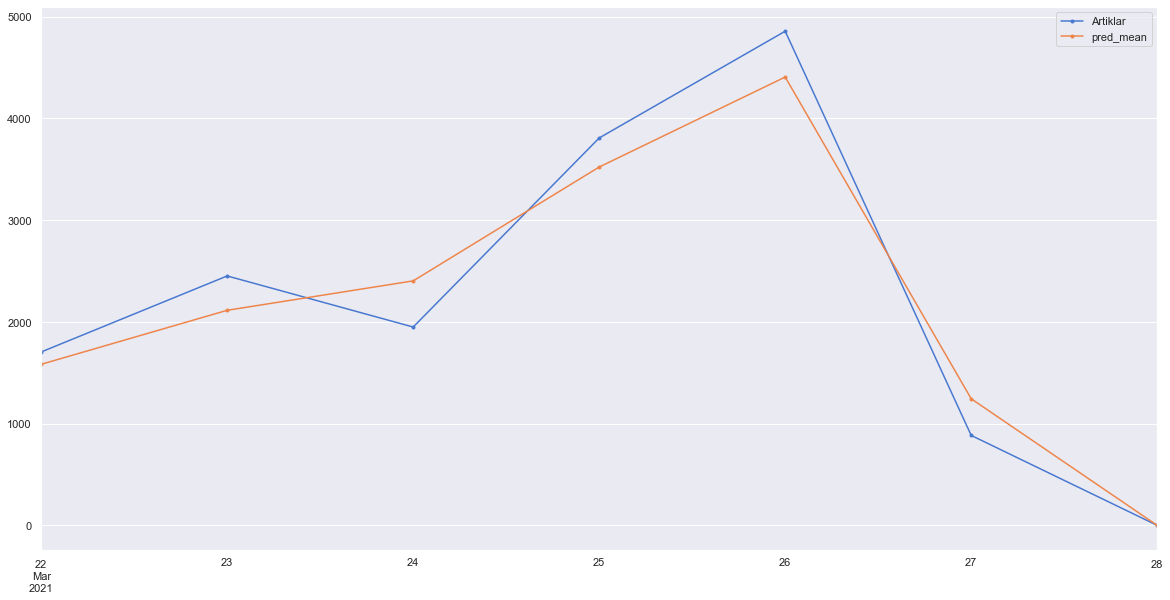

In [134]:
predictions['Artiklar'].plot(figsize=(20,10), legend=True, marker='.')
predictions['pred_mean'].plot(legend=True, figsize=(20,10), marker='.')

In [ ]:
score = {'RMSE': np.sqrt(mean_squared_error(y_true=predictions['Artiklar'], y_pred=predictions['pred_mean'])),
         'MAE': mean_absolute_error(y_true=predictions['Artiklar'], y_pred=predictions['pred_mean']),
         'r2': r2_score(y_true=predictions['Artiklar'], y_pred=predictions['pred_mean'])}
score

In [ ]:
{'RMSE': 385.78641348726325,
 'MAE': 324.01567163148974,
 'r2': 0.9371325401517963}